In [28]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from pylab import *

In [29]:
london_20 = 'london_square'
paris_20 = 'paris_square_20'

In [30]:
meta_ld, cirs_ld, dist_ld, Y_all_ld, RX_all_ld, _, _ = read_mat(london_20)
meta_pr, cirs_pr, dist_pr, Y_all_pr, RX_all_pr, _, _ = read_mat(paris_20)

In [99]:
geodesic(Y_all_ld[0], Y_all_ld[1])

Distance(0.05263154052873037)

# Preprocess

In [41]:
def distance_tr(TX, RX):
    """Calculate distance between every tx and rx"""
    new_dist = []
    for t in TX:
        new_dist.append(np.array([
            geodesic(t, r).m for r in RX
        ]))
    return np.array(new_dist)

In [43]:
new_dist_ld = distance_tr(Y_all_ld, RX_all_ld)

In [44]:
ext_ld = Extractor(cirs_ld, RX_all_ld)
ext_pr = Extractor(cirs_pr, RX_all_pr)


# X_ld = ext_ld.formatting_X()
# X_pr = ext_pr.formatting_X()

X_ld = ext_ld.amplitute_feature()
X_pr = ext_pr.amplitute_feature(ext_ld.max_reflection)

# X_ld = ext_ld.coord_feature()
# X_pr = ext_pr.coord_feature()

d:\Telecom_2eme_anne\Geolocation_simulation\Simulation\tools.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))


In [6]:
from sklearn.neighbors import KernelDensity

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


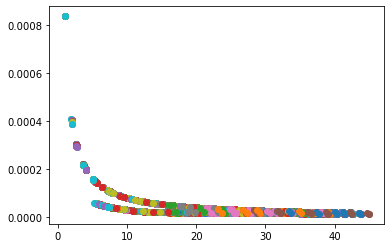

In [8]:
cir_profile = cirs_pr

T, S = cir_profile.shape

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** 7 # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
        plt.scatter(c_tmp[0, :], c_tmp[1, :])

# Learning

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb

In [46]:
xgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

rf_pipe = Pipeline([('scale', StandardScaler()), ('rf', RF(max_depth=2000))])

dt_pipe = Pipeline([('scale', StandardScaler()), ('dt', DT(max_depth=2000))])

In [47]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, dt_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'DT']

In [50]:
class TransferFitting(object):
    def __init__(self, X, dist, Y, RX) -> None:
        self.X, self.dist, self.Y, self.RX = X, dist, Y, RX

        self.grid_num = int(np.sqrt(self.X.shape[0]))
        self.x_train, self.x_test, self.dist_train, self.dist_test, self.y_train, self.y_test = train_test_split(self.X, self.dist, self.Y, train_size=.75)
        # self.grid_lat, self.grid_lon = round(geodesic(self.Y[1, :], self.Y[1 + self.grid_num, :]).m, 2), \
        #     round(geodesic(self.Y[1, :], self.Y[2, :]).m, 2)

    def fitting(self, model):
        model.fit(self.x_train, self.dist_train)
        

In [51]:
x_train, x_test, dist_train, dist_test, tx_train, tx_test = train_test_split(X_ld, new_dist_ld, Y_all_ld, train_size=.75)


In [84]:
_ = lgb_pipe.fit(x_train, dist_train)

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [85]:
dist_pr_pred = lgb_pipe.predict(X_pr)

## Optimization

In [56]:
from scipy.optimize import minimize, Bounds

In [57]:
def dist2coord(x, coords, dists):

    d = np.array([geodesic(x, coord).m for coord in coords])

    return np.linalg.norm([d-dists])**2

def find_x(coords, dists):
    """find x through distance and rx coordinates"""
    x_pred = []

    bounds = Bounds([0, -90], [90, 90])

    for i, p in enumerate(dists):
        res = minimize(
        dist2coord,
        coords[0],
        args=(coords, p),
        method='L-BFGS-B',
        options={
            'ftol':1e-5,         # Tolerance
            'maxiter': 1e+7      # Maximum iterations
        },
        bounds=bounds
    )   

        x_pred.append(res.x)

    return np.array(x_pred)

In [86]:
loc_ld_pred = find_x(RX_all_ld, lgb_pipe.predict(x_test))

In [87]:
ld_dist_err = dist_from_geo(loc_ld_pred, tx_test)

In [88]:
loc_pr_pred = find_x(RX_all_pr, dist_pr_pred)

In [89]:
pr_dist_err = dist_from_geo(loc_pr_pred, Y_all_pr)

In [90]:
def cdf_plot(data, ax=plt, label=None):
    n = len(data)
    x = np.arange(n) / (n-1)
    y = np.sort(data)

    ax.plot(y, x, label=label)

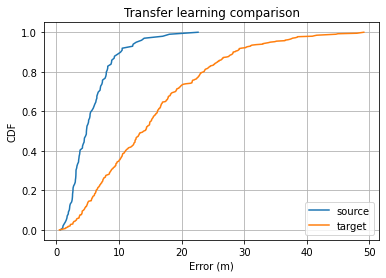

In [100]:
cdf_plot(ld_dist_err, label='source')
cdf_plot(pr_dist_err, label='target')
plt.title('Transfer learning comparison')
plt.ylabel('CDF')
plt.xlabel('Error (m)')
plt.legend(loc='best')
plt.grid()

# Algo comparison

In [92]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, dt_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'DT']

In [93]:
pf_ld = PipesFitting(X_ld, Y_all_ld, RX_all_ld)
pf_ld.add_pipes(pipes, model_ls)
pf_ld.fit()

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


Text(0.5, 0, 'Error (m)')

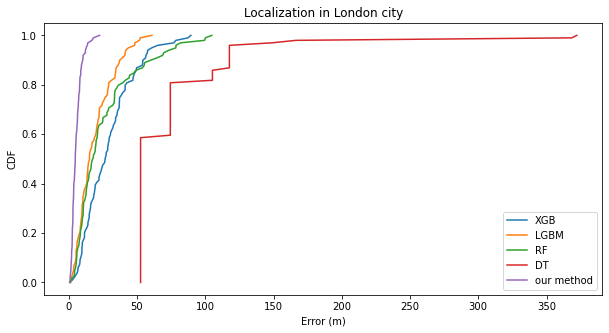

In [95]:
fig, ax = plt.subplots(figsize=(10,5))
dists_all = pf_ld.dist_all
for mode, dists in zip(model_ls, dists_all):
    cdf_plot(dists, ax=ax, label=mode)

cdf_plot(ld_dist_err, ax=ax, label='our method')
plt.legend()
plt.title('Localization in London city')
plt.ylabel('CDF')
plt.xlabel('Error (m)')

In [77]:
len(pf_ld.dist_all), len(pf_ld.dist_all[0])

(4, 100)